In [2]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) # 이 두줄은 본 필자가 항상 쓰는 방법입니다. matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')



%matplotlib inline

df_train = pd.read_csv('./data1/train.csv')
df_test = pd.read_csv('./data1/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야하니 1을 더합니다

df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

## 3. Feature engineering
- 본격적인 feature engineering 을 시작해보겠습니다.
- 가장 먼저, dataset 에 존재하는 null data를 채우려고 합니다.
- 아무 숫자로 채울 수는 없고, null data 를 포함하는 feature 의 statistics 를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.
- null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분입니다.
- Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만아닐라 test 도 똑같이 적용해주어야 합니다. 잊지맙시다.

## 3.1 Fill Null
## 3.1.1 Fill Null in Age using title
- Age 에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics 를 사용해 보겠습니다.
- 영어에서는 Miss, Mrr, Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title 이 들어가게 되는데 이를 사용해보겠습니다.
- pandas series 에는 data 를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title 을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다

In [3]:
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

- pandas 의 crosstab 을 이용하여 우리가 추출한 Initial 과 Sex 간의 count 를 살펴봅시다.

In [4]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


- 위 table 을 참고하여, 남자, 여자가 쓰는 initial 을 구분해 보겠습니다. replace 메소드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해줍니다.

In [5]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [6]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


<AxesSubplot:xlabel='Initial'>

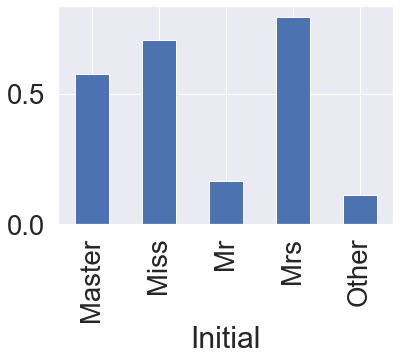

In [7]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

- 이제 본격적으로 Null 을 채울 것입니다. null data 를 채우는 방법은 정말 많이 존재합니다. statistics 를 활용하는 방법도 있고, null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics 를 활용하는 방법을 사용할 것입니다.
- 여기서 statistics 는 train data 의 것을 의미합니다. 우리는 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test 의 null data 를 채워줘야 합니다.

In [8]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


- Age의 평균을 이용해 Null value 를 채우도록 하겠습니다.
- pandas dataframe 을 다룰 때에는 boolean array를 이용해 indexing 하는 방법이 참으로 편리합니다.
- 아래 코드 첫줄을 해석하자면, isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다 입니다.
- loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [9]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

- 여기선 간단하게 Null을 채웠지만, 좀 더 다양한 방법을 쓴 예시들이 다른 커널에 존재합니다
- https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling 보시면서 공부해보세요!
- 이 외에도 다른 캐글러들의 커널을 보며 여러 참신한 아이디어를 살펴보세요!

## 3.1.2 Fill Null in Embarked

In [10]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), ' Null values')

Embarked has  2  Null values


- Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채우겠습니다.
- dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True 로 하면 df_train 에 fillna 를 실제로 적용하게 됩니다

In [12]:
df_train['Embarked'].fillna('S', inplace=True)